In [1]:
%matplotlib inline

import json
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [2]:
import re

def parse_time(time_str):
    match = re.match('(\d\d):([\d.]+)', time_str)
    if match:
        return 60 * int(match.group(1)) + float(match.group(2))

def parse_report(path):
    with open(path) as f:
        html = f.read()
    for dataset, query, time in re.findall(r'dataset: ([a-z\d_]+).*?query: ([\w\- ]+).*?query time: ([\d:.]+)', html, flags=re.IGNORECASE):
        seconds = parse_time(time)
        yield dataset, query, seconds

report = []
for path in ('data/testbot_allsq_report1.12.html', 'data/testbot_allsq_report2.12.html'):
    for dataset, query, seconds in parse_report(path):
        report.append(dict(dataset=dataset, query=query, time=seconds, version='1.4.12.3'))
for path in ('data/testbot_allsq_report1.13.2.html',):
    for dataset, query, seconds in parse_report(path):
        report.append(dict(dataset=dataset, query=query, time=seconds, version='1.4.13.2'))
df = pd.DataFrame(report)
df

,dataset,query,time,version
0,activity20,describe countryname,2.10,1.4.12.3
1,activity20,describe dob,2.00,1.4.12.3
2,activity20,describe height,2.10,1.4.12.3
3,activity20,describe lastsynctime,2.50,1.4.12.3
4,activity20,describe number_of_rows,2.50,1.4.12.3
5,activity20,describe numsleepsessions,2.30,1.4.12.3
6,activity20,describe regionname,2.30,1.4.12.3
7,activity20,describe sex,2.30,1.4.12.3
8,activity20,forecast activedays in the next 30 days of las...,5.16,1.4.12.3
9,activity20,forecast avgdailypoints_activedays in the next...,4.83,1.4.12.3


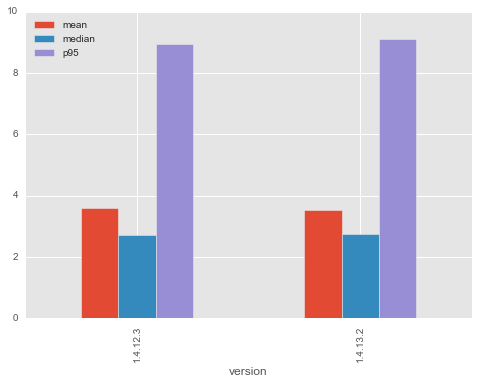

In [3]:
def p95(arr):
    return np.percentile(arr, 95)

df.groupby('version').agg({'time': [np.mean, np.median, p95]})['time'].plot.bar()

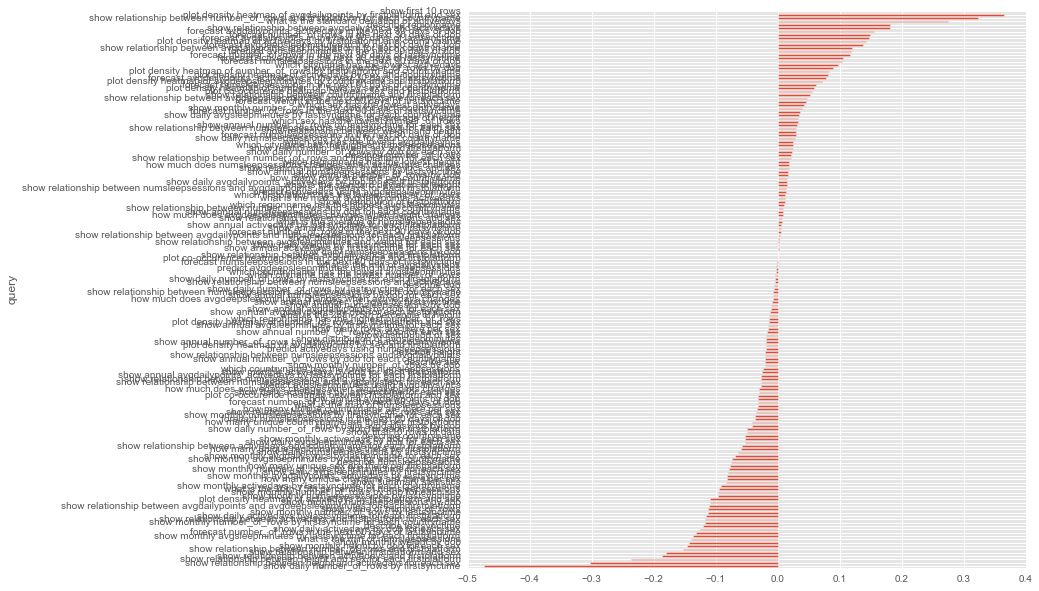

In [4]:
v12_mean = df[df['version'] == '1.4.12.3'].groupby('query').mean()
v13_mean = df[df['version'] == '1.4.13.2'].groupby('query').mean()

mean_diff = (v13_mean['time'] - v12_mean['time']) / v12_mean['time']
plt.figure(figsize=(10,10))
mean_diff.sort_values().plot.barh()

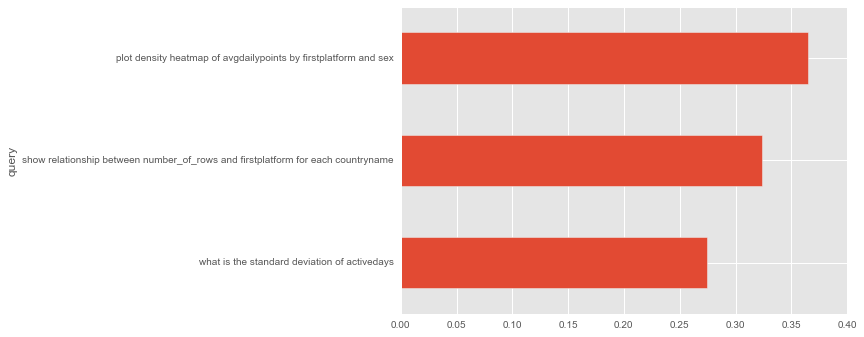

In [5]:
mean_diff[mean_diff > 0.2].sort_values().plot.barh()

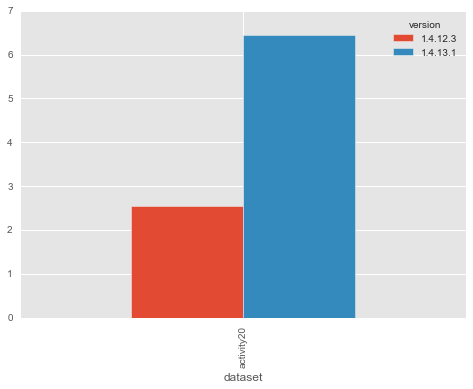

In [6]:
def parse_report_connect_time(path):
    with open(path) as f:
        html = f.read()
    for dataset, time in re.findall(r'connect to dataset ([a-z0-9_]+): ([\d:.]+)', html, flags=re.IGNORECASE):
        seconds = parse_time(time)
        yield dataset, seconds

report = []
for path in ('data/testbot_allsq_report1.12.html', 'data/testbot_allsq_report2.12.html'):
    for dataset, seconds in parse_report_connect_time(path):
        report.append(dict(dataset=dataset, time=seconds, version='1.4.12.3'))
for path in ('data/testbot_allsq_report1.13.html', 'data/testbot_allsq_report2.13.html'):
    for dataset, seconds in parse_report_connect_time(path):
        report.append(dict(dataset=dataset, time=seconds, version='1.4.13.1'))
connect_df = pd.DataFrame(report)

grp = connect_df.groupby(['version', 'dataset']).mean()
grp.unstack('version')['time'].plot.bar()

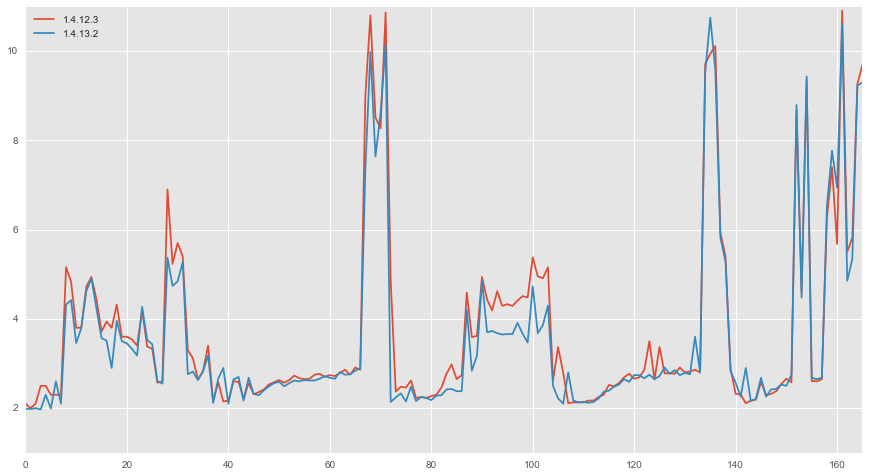

In [7]:
report_12 = []
for dataset, query, seconds in parse_report('data/testbot_allsq_report1.12.html'):
    report_12.append(dict(dataset=dataset, query=query, time=seconds, version='1.4.12.3'))
    
report_13 = []
for dataset, query, seconds in parse_report('data/testbot_allsq_report1.13.2.html'):
    report_13.append(dict(dataset=dataset, query=query, time=seconds, version='1.4.13.2'))

df12 = pd.DataFrame(report_12)
df13 = pd.DataFrame(report_13)
df = pd.concat([df12[['time']], df13[['time']]], axis=1)
df.columns = ['1.4.12.3', '1.4.13.2']
df.plot(figsize=(15, 8))

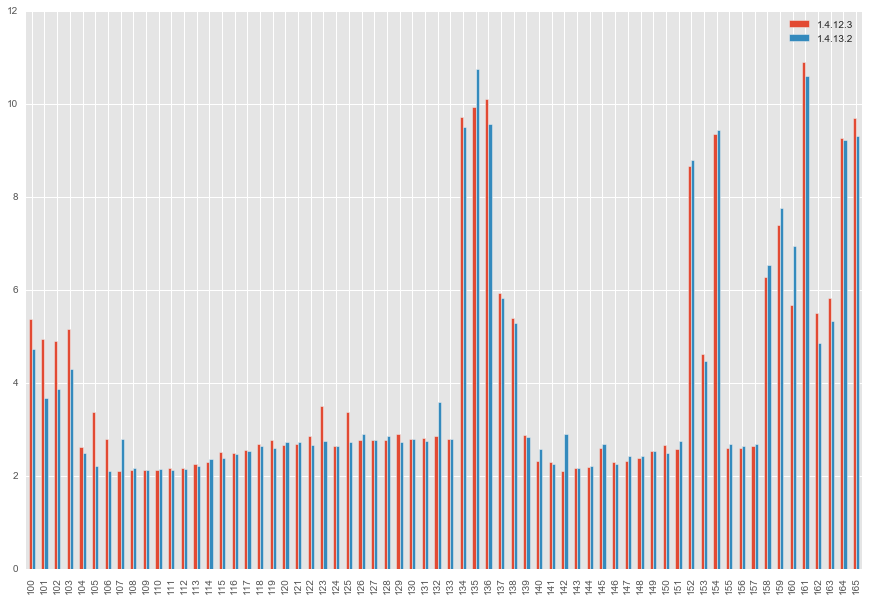

In [8]:
df[100:].plot.bar(figsize=(15, 10))